<a href="https://colab.research.google.com/github/Souvik2biswas/Solar-cycle-prediction/blob/main/SUN1cycRidge26.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 kB 2.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error as MSE

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data=pd.read_csv('/content/drive/MyDrive/Datasets/monthlySSA.csv')
data

,DATE,Area
0,1874-05-01,365.1
1,1874-06-01,415.2
2,1874-07-01,1033.5
3,1874-08-01,954.1
4,1874-09-01,335.3
...,...,...
1783,2022-12-01,1326.4
1784,2023-01-01,1846.2
1785,2023-02-01,1278.5
1786,2023-03-01,1013.2


In [ ]:
data['DATE']=pd.to_datetime(data['DATE'])
data=data.set_index('DATE')

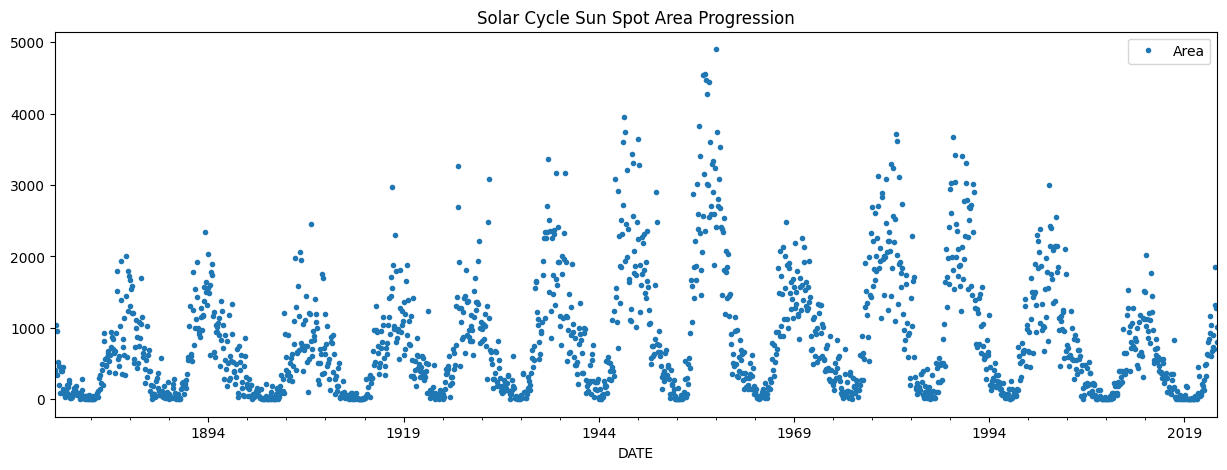

In [ ]:
data.plot(style='.',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [ ]:
data

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2022-12-01,1326.4
2023-01-01,1846.2
2023-02-01,1278.5


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1788 entries, 1874-05-01 to 2023-04-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1788 non-null   float64
dtypes: float64(1)
memory usage: 27.9 KB


<Axes: title={'center': 'Peaks'}, xlabel='DATE'>

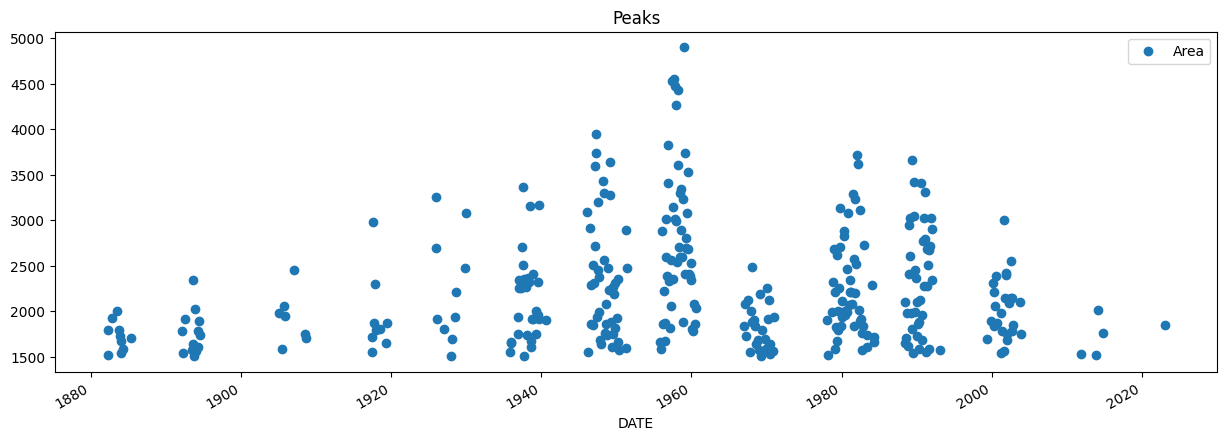

In [ ]:
data.query('Area > 1500')\
    .plot(style='o',
          figsize=(15, 5),
          title='Peaks')

In [ ]:
data.query('Area == 0')

,Area
DATE,
1878-08-01,0.0
1879-02-01,0.0
1879-03-01,0.0
1889-11-01,0.0
1900-12-01,0.0
1901-04-01,0.0
1901-08-01,0.0
1901-12-01,0.0
1902-04-01,0.0


In [ ]:
data.query('Area < 20')

,Area
DATE,
1876-04-01,15.8
1876-06-01,15.2
1877-07-01,4.2
1878-01-01,14.9
1878-02-01,18.1
...,...
2020-02-01,1.4
2020-03-01,1.4
2020-04-01,7.5


In [ ]:
a = data.query('Area < 1000')
b = data.query('Area < 20')
c = data.query('Area > 1000')
plt.figure(figsize=(20,5), dpi=1000)
plt.scatter(x=a.index, y=a, marker='.', label='middle values')
plt.scatter(x=c.index, y=c, marker='.', label='higher values')
plt.scatter(x=b.index, y=b, marker='.', edgecolors='black', label='nearly zero values')
plt.legend(['upper values', 'middle values','zero values'])
plt.show()

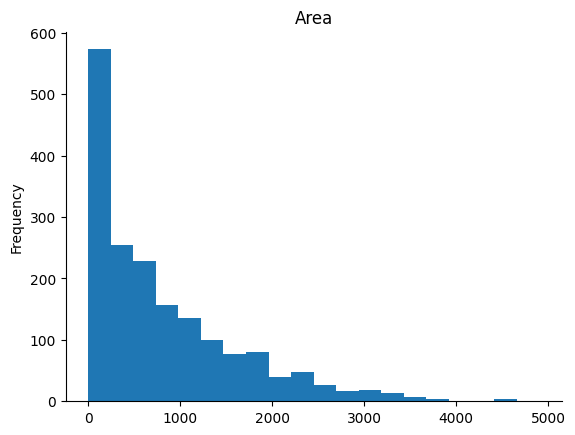

In [ ]:
data['Area'].plot(kind='hist', bins=20, title='Area')
plt.gca().spines[['top', 'right',]].set_visible(False)

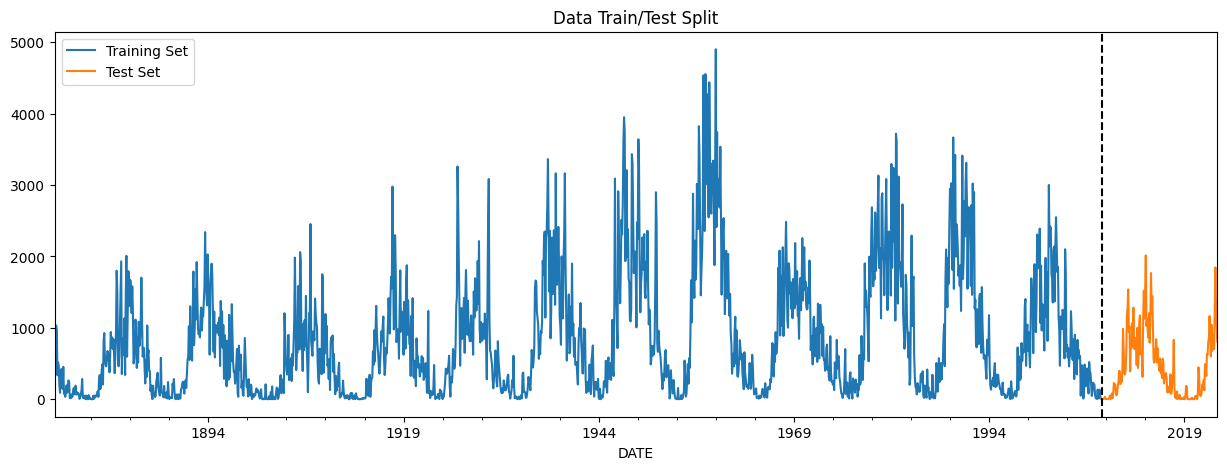

In [ ]:
train_scaled = data.loc[data.index < '2008-06-01']
test_scaled = data.loc[data.index >= '2008-06-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_scaled.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_scaled.plot(ax=ax, label='Test Set')
ax.axvline('2008-06-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
train_scaled

,Area
DATE,
1874-05-01,365.1
1874-06-01,415.2
1874-07-01,1033.5
1874-08-01,954.1
1874-09-01,335.3
...,...
2008-01-01,12.2
2008-02-01,11.1
2008-03-01,133.2


In [ ]:
def prepare_data(timeseries_data, n_steps):
    X, y =[],[]
    for i in range(len(timeseries_data)):
        end_ix = i + n_steps
        if end_ix > len(timeseries_data)-1:
            break
        seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [ ]:
n_steps=96
X,y=prepare_data(train_scaled['Area'],n_steps)
val_X,val_y=prepare_data(test_scaled['Area'],n_steps)

In [ ]:
X.shape

(1513, 96)

In [ ]:
val_X.shape

(83, 96)

In [ ]:
X

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [2306.4, 1834. , 2216.1, ...,  135.9,   12.2,   11.1],
       [1834. , 2216.1, 2055.2, ...,   12.2,   11.1,  133.2],
       [2216.1, 2055.2, 2389.5, ...,   11.1,  133.2,   40.6]])

In [ ]:
from skopt.space import Real, Categorical, Integer

param_grid = {
    'alpha': Real(1e-4, 1),
    'copy_X': [True],
    'tol': Real(1e-10, 1e-4),
    'solver': ['svd', 'lsqr', 'sparse_cg', 'saga'],
    'max_iter': Integer(10, 200),
    'random_state': Integer(0, 500)
}

In [ ]:
ts_cv = TimeSeriesSplit(
    n_splits=5,
    gap=5,
    max_train_size=1800,
    test_size=180,
)

In [ ]:
rid_model = Ridge()

In [ ]:
import skopt
from skopt import BayesSearchCV
np.int = np.int64

bay_search = BayesSearchCV(estimator = rid_model,
                    search_spaces = param_grid,
                    n_iter = 50,
                    cv = ts_cv,
                    scoring = 'neg_mean_squared_error')

bay_search.fit(X, y)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=1800, n_splits=5, test_size=180),
              estimator=Ridge(), scoring='neg_mean_squared_error',
              search_spaces={'alpha': Real(low=0.0001, high=1, prior='uniform', transform='normalize'),
                             'copy_X': [True],
                             'max_iter': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'random_state': Integer(low=0, high=500, prior='uniform', transform='normalize'),
                             'solver': ['svd', 'lsqr', 'sparse_cg', 'saga'],
                             'tol': Real(low=1e-10, high=0.0001, prior='uniform', transform='normalize')})

In [ ]:
print("val. score: %s" % bay_search.best_score_)
print("test score: %s" % bay_search.score(X, y))
print("best params: %s" % str(bay_search.best_params_))

val. score: -271878.4343719653
test score: -181453.6230543004
best params: OrderedDict([('alpha', 1.0), ('copy_X', True), ('max_iter', 10), ('random_state', 4), ('solver', 'saga'), ('tol', 9.7551795940186e-05)])


In [ ]:
best_params = bay_search.best_params_
best_model = bay_search.best_estimator_

In [ ]:
predictions = best_model.predict(val_X).reshape(-1,1)
predictions

array([[ 4.61738526e+02],
       [ 3.04175652e+02],
       [ 3.07854725e+02],
       [ 2.92420727e+02],
       [ 2.96950941e+02],
       [ 3.50880874e+02],
       [ 2.40217316e+02],
       [ 2.16398604e+02],
       [ 1.72952524e+02],
       [ 1.43034473e+02],
       [ 1.02538296e+01],
       [ 1.46358537e+02],
       [ 2.61448423e-01],
       [ 1.36981429e+02],
       [ 1.40438944e+02],
       [ 1.56486129e+02],
       [ 4.40312210e+02],
       [ 2.51851035e+02],
       [ 2.05240350e+02],
       [ 5.30888129e+01],
       [ 1.62641681e+02],
       [ 1.11810109e+02],
       [-1.60179184e+01],
       [ 7.54486445e+01],
       [ 1.64863955e+02],
       [ 1.77898647e+02],
       [ 7.76347307e+01],
       [ 9.11665372e+01],
       [ 8.94785835e+01],
       [ 2.14549865e+02],
       [ 1.49548686e+02],
       [-2.79069207e+01],
       [ 6.91966569e+01],
       [ 5.80632687e+01],
       [ 8.47632428e+01],
       [ 2.79425825e+02],
       [ 2.63007052e+02],
       [ 1.50638112e+02],
       [ 1.1

In [ ]:
RMSE = np.sqrt(MSE(predictions,val_y))
RMSE

194.93681040888185

In [ ]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions,val_y)
R2_score

0.6274156297748871

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions, val_y)
MAPE

7.453065028264574

In [ ]:
train_predict = best_model.predict(X).reshape(-1,1)
test_predict = best_model.predict(val_X).reshape(-1,1)

In [ ]:
test = np.vstack((train_predict,test_predict))

In [ ]:
data_scaled1=data[96:]

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled1)))

In [ ]:
test=test.flatten()

In [ ]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date)

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date[:-96])

In [ ]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new.head()

,original,predicted
1882-05,1519.6,1253.587836
1882-06,557.8,1210.096888
1882-07,461.5,889.699367
1882-08,607.6,756.535913
1882-09,1026.9,808.487595


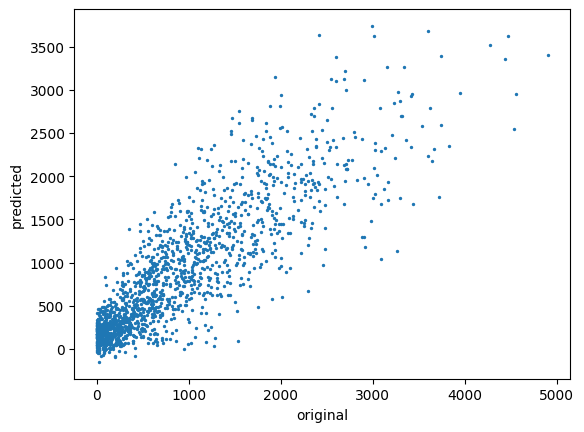

In [ ]:
from matplotlib import pyplot as plt
new.plot(kind='scatter', x='original', y='predicted', s=2, alpha=1)
plt.gca().spines[['top', 'right',]].set_visible(True)

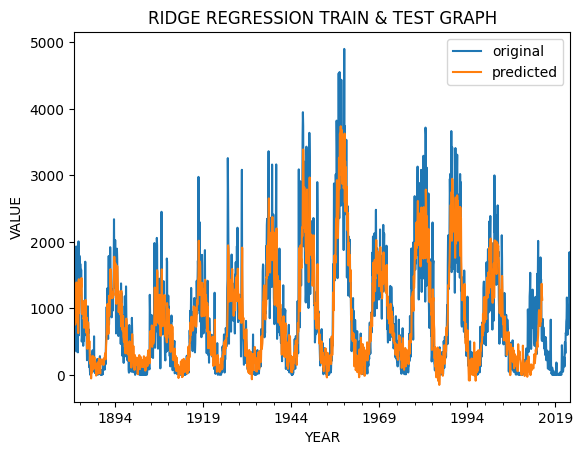

In [ ]:
new.plot()
plt.title('RIDGE REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [ ]:
len(test_predict),len(val_y)

(83, 83)

In [ ]:
len(data)

1788

In [ ]:
#data_n=data[:1759]

In [ ]:
#data_n

In [ ]:
import numpy as np

t_df = np.array(data).reshape(-1,1)

In [ ]:
len(t_df)

1788

In [ ]:
fut_inp = t_df[1692:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 96)

In [ ]:
tmp_inp = tmp_inp[0].tolist()

In [ ]:
predictions

array([[ 4.61738526e+02],
       [ 3.04175652e+02],
       [ 3.07854725e+02],
       [ 2.92420727e+02],
       [ 2.96950941e+02],
       [ 3.50880874e+02],
       [ 2.40217316e+02],
       [ 2.16398604e+02],
       [ 1.72952524e+02],
       [ 1.43034473e+02],
       [ 1.02538296e+01],
       [ 1.46358537e+02],
       [ 2.61448423e-01],
       [ 1.36981429e+02],
       [ 1.40438944e+02],
       [ 1.56486129e+02],
       [ 4.40312210e+02],
       [ 2.51851035e+02],
       [ 2.05240350e+02],
       [ 5.30888129e+01],
       [ 1.62641681e+02],
       [ 1.11810109e+02],
       [-1.60179184e+01],
       [ 7.54486445e+01],
       [ 1.64863955e+02],
       [ 1.77898647e+02],
       [ 7.76347307e+01],
       [ 9.11665372e+01],
       [ 8.94785835e+01],
       [ 2.14549865e+02],
       [ 1.49548686e+02],
       [-2.79069207e+01],
       [ 6.91966569e+01],
       [ 5.80632687e+01],
       [ 8.47632428e+01],
       [ 2.79425825e+02],
       [ 2.63007052e+02],
       [ 1.50638112e+02],
       [ 1.1

In [ ]:
lst_output=[]
n_steps=96
i=0
while(i<120):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

lst_output

[[1003.6274093731475],
 [1106.6395434354795],
 [1157.6945020520434],
 [1152.179155487034],
 [1097.2764439226985],
 [1195.2797115107333],
 [1224.0961153826972],
 [1235.2877099696793],
 [1252.1899269056998],
 [1223.7888927529327],
 [1279.9128216030053],
 [1285.3413132039132],
 [1356.9857624352746],
 [1306.42362095027],
 [1231.386880854587],
 [1247.542739597128],
 [1197.1441367749578],
 [1224.7762625837454],
 [1314.9147529642962],
 [1293.4732453648878],
 [1217.6023858221492],
 [1313.1875770933282],
 [1304.3574025633186],
 [1265.6739294629094],
 [1271.0170814140922],
 [1169.1891115439391],
 [1160.7901554612026],
 [1159.4456401338475],
 [1179.0543541897032],
 [1105.6363775186219],
 [1092.3191303060894],
 [1096.1474899799205],
 [1132.2701792979499],
 [1183.4304771659831],
 [1116.2276231955668],
 [1036.1608602143515],
 [993.2203066165424],
 [1005.040417185716],
 [1017.9853928524414],
 [958.313238705527],
 [955.442384972449],
 [930.8154024534857],
 [932.7866357202765],
 [938.8087855291708],
 [

In [ ]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [ ]:
X1.shape

(1692, 96, 1)

In [ ]:
X1 = np.array([X1]).reshape(1692, 96)

In [ ]:
train_p=best_model.predict(X1).reshape(-1,1)

In [ ]:
type(train_p)

numpy.ndarray

In [ ]:
test = np.vstack((train_p,lst_output))

In [ ]:
test=test.flatten()

In [ ]:
data_n = np.array(data).reshape(-1,1)

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(data_scaled1)+120))

In [ ]:
DF = pd.DataFrame()
DF['original'] = data_scaled1
DF = DF.set_index(date[:-120])

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test
DF1 = DF1.set_index(date)

In [ ]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new

,original,predicted
1882-05,1519.6,1253.587836
1882-06,557.8,1210.096888
1882-07,461.5,889.699367
1882-08,607.6,756.535913
1882-09,1026.9,808.487595
...,...,...
2032-12,NaN,993.307794
2033-01,NaN,1005.574615
2033-02,NaN,1008.742990
2033-03,NaN,1025.514461


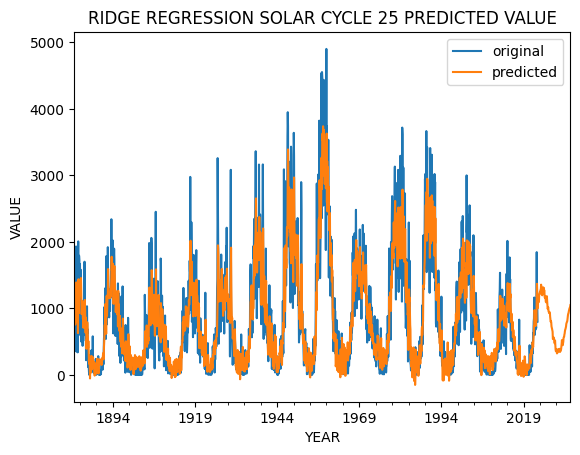

In [ ]:
new.plot()
plt.title('RIDGE REGRESSION SOLAR CYCLE 25 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [ ]:
print("Largest element is:", max(lst_output))

Largest element is: [1356.9857624352746]


In [ ]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

<ipython-input-68-75ffc8ac41e8>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time=int(np.where(np.array(lst_output) == i)[0])


12

In [ ]:
new_date = np.datetime64('2023-05') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


Peak month is : 2024-05


In [ ]:
new.query('predicted <= 0')

,original,predicted
1887-02,75.6,-52.765219
1888-07,22.2,-10.289556
1911-12,15.5,-46.293234
1912-01,0.0,-16.013169
1912-12,81.6,-32.647117
1913-02,23.2,-26.022745
1932-10,71.0,-65.446085
1954-01,0.7,-23.378285
1954-02,1.4,-37.642316
1963-04,303.0,-35.173084


In [ ]:
output = np.array(lst_output)
output.flatten()

array([1003.62740937, 1106.63954344, 1157.69450205, 1152.17915549,
       1097.27644392, 1195.27971151, 1224.09611538, 1235.28770997,
       1252.18992691, 1223.78889275, 1279.9128216 , 1285.3413132 ,
       1356.98576244, 1306.42362095, 1231.38688085, 1247.5427396 ,
       1197.14413677, 1224.77626258, 1314.91475296, 1293.47324536,
       1217.60238582, 1313.18757709, 1304.35740256, 1265.67392946,
       1271.01708141, 1169.18911154, 1160.79015546, 1159.44564013,
       1179.05435419, 1105.63637752, 1092.31913031, 1096.14748998,
       1132.2701793 , 1183.43047717, 1116.2276232 , 1036.16086021,
        993.22030662, 1005.04041719, 1017.98539285,  958.31323871,
        955.44238497,  930.81540245,  932.78663572,  938.80878553,
        940.5260541 ,  875.86426838,  843.81830647,  798.85943578,
        809.52937402,  789.13795533,  729.53427001,  713.8828347 ,
        692.8428601 ,  668.06045825,  650.12211776,  538.84424149,
        545.76471549,  553.94090173,  563.70633371,  551.44110

In [ ]:
len(output)

120

In [ ]:
train_d = np.array(data['Area'])
train_d.flatten()

array([ 365.1,  415.2, 1033.5, ..., 1278.5, 1013.2,  802. ])

In [ ]:
n_data = np.append(train_d, output)

In [ ]:
n_data.shape

(1908,)

In [ ]:
DATE = pd.Series(pd.period_range("1874-05-01", freq="M", periods=len(n_data)))

In [ ]:
new_d = pd.DataFrame()
new_d['Area'] = n_data
new_d = new_d.set_index(DATE)

In [ ]:
new_d.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 1908 entries, 1874-05 to 2033-04
Freq: M
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Area    1908 non-null   float64
dtypes: float64(1)
memory usage: 29.8 KB


In [ ]:
new_d

,Area
1874-05,365.100000
1874-06,415.200000
1874-07,1033.500000
1874-08,954.100000
1874-09,335.300000
...,...
2032-12,993.307794
2033-01,1005.574615
2033-02,1008.742990
2033-03,1025.514461


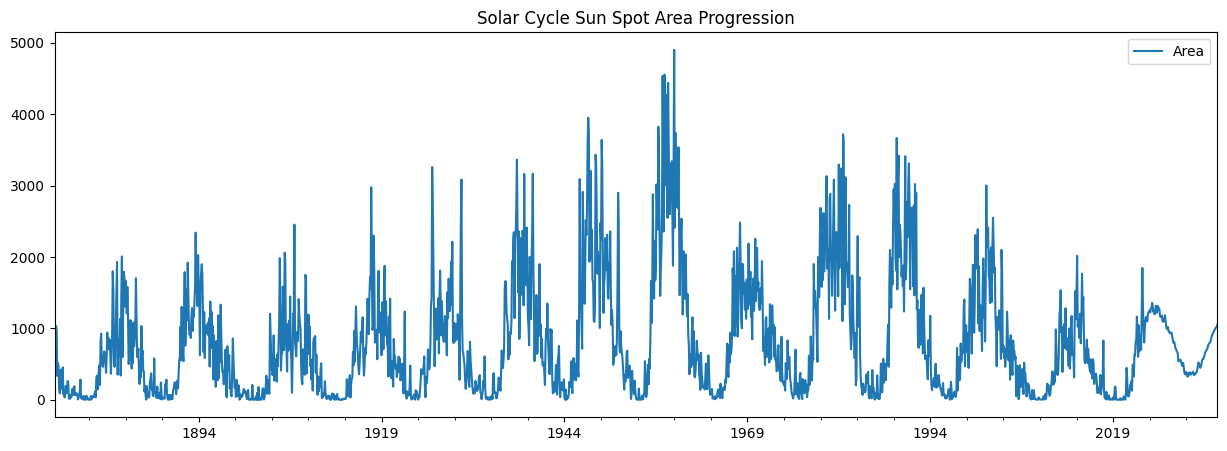

In [ ]:
new_d.plot(style='-',
        figsize=(15, 5),
        title='Solar Cycle Sun Spot Area Progression')
plt.show()

In [ ]:
new_d.query('Area < 10')

,Area
1877-07,4.2
1878-04,0.4
1878-07,0.4
1878-08,0.0
1878-10,9.6
...,...
2020-02,1.4
2020-03,1.4
2020-04,7.5
2020-05,1.8


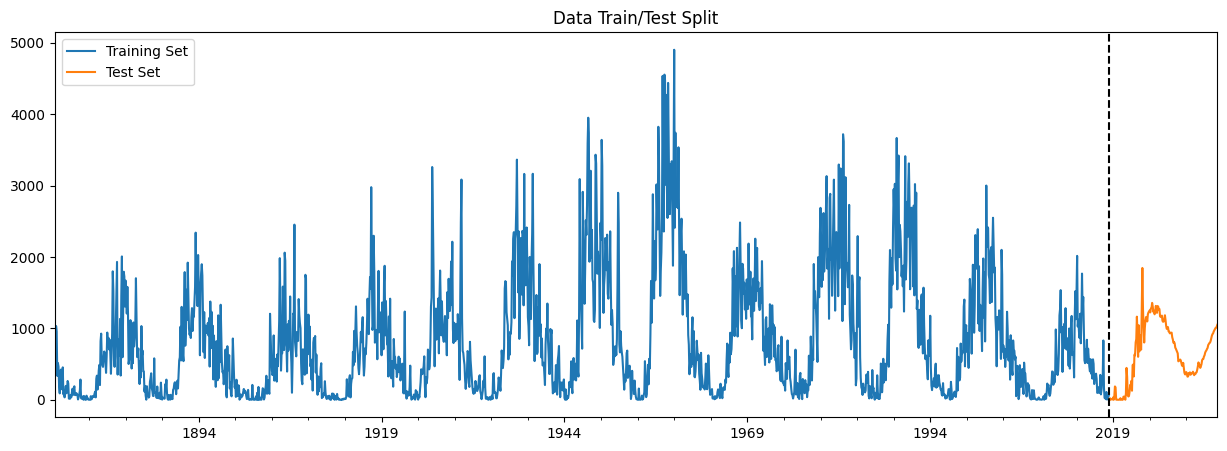

In [ ]:
train_d = new_d.loc[new_d.index < '2018-07-01']
test_d = new_d.loc[new_d.index >= '2018-07-01']
fig, ax = plt.subplots(figsize=(15, 5))
train_d.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test_d.plot(ax=ax, label='Test Set')
ax.axvline('2018-07-01', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])
plt.show()

In [ ]:
test_d

,Area
2018-07,0.500000
2018-08,21.200000
2018-09,1.900000
2018-10,7.700000
2018-11,11.200000
...,...
2032-12,993.307794
2033-01,1005.574615
2033-02,1008.742990
2033-03,1025.514461


In [ ]:
n_steps=96
Xd,yd=prepare_data(train_d['Area'],n_steps)
val_Xd,val_yd=prepare_data(test_d['Area'],n_steps)

In [ ]:
Xd.shape

(1634, 96)

In [ ]:
val_Xd.shape

(82, 96)

In [ ]:
Xd

array([[ 365.1,  415.2, 1033.5, ...,  673.1,  928.9, 1799.1],
       [ 415.2, 1033.5,  954.1, ...,  928.9, 1799.1, 1519.6],
       [1033.5,  954.1,  335.3, ..., 1799.1, 1519.6,  557.8],
       ...,
       [  85.4,   54.9,   85.9, ...,    8.6,  109.5,    2.7],
       [  54.9,   85.9,  182.5, ...,  109.5,    2.7,   28. ],
       [  85.9,  182.5,  234.4, ...,    2.7,   28. ,   33.9]])

In [ ]:
ts_cv2 = TimeSeriesSplit(
    n_splits=5,
    gap=5,
    max_train_size=1950,
    test_size=178,
)

In [ ]:
import skopt
from skopt import BayesSearchCV
np.int = np.int64

bay_search = BayesSearchCV(estimator = rid_model,
                    search_spaces = param_grid,
                    n_iter = 50,
                    cv = ts_cv2,
                    scoring = 'neg_mean_squared_error')

bay_search.fit(Xd, yd)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

BayesSearchCV(cv=TimeSeriesSplit(gap=5, max_train_size=1950, n_splits=5, test_size=178),
              estimator=Ridge(), scoring='neg_mean_squared_error',
              search_spaces={'alpha': Real(low=0.0001, high=1, prior='uniform', transform='normalize'),
                             'copy_X': [True],
                             'max_iter': Integer(low=10, high=200, prior='uniform', transform='normalize'),
                             'random_state': Integer(low=0, high=500, prior='uniform', transform='normalize'),
                             'solver': ['svd', 'lsqr', 'sparse_cg', 'saga'],
                             'tol': Real(low=1e-10, high=0.0001, prior='uniform', transform='normalize')})

In [ ]:
print("val. score: %s" % bay_search.best_score_)
print("test score: %s" % bay_search.score(Xd, yd))
print("best params: %s" % str(bay_search.best_params_))

val. score: -249439.03975808164
test score: -173194.56066592835
best params: OrderedDict([('alpha', 1.0), ('copy_X', True), ('max_iter', 10), ('random_state', 0), ('solver', 'saga'), ('tol', 0.0001)])


In [ ]:
best_params = bay_search.best_params_
best_model = bay_search.best_estimator_

In [ ]:
predictions2 = best_model.predict(val_Xd).reshape(-1,1)
predictions2

array([[1010.4427567 ],
       [ 957.67802829],
       [ 949.06569752],
       [ 922.66364346],
       [ 925.57996242],
       [ 931.94141511],
       [ 930.46852546],
       [ 870.85341549],
       [ 843.91171908],
       [ 801.90828025],
       [ 806.48914153],
       [ 787.84269772],
       [ 725.19916947],
       [ 710.87197018],
       [ 691.18313047],
       [ 664.25222633],
       [ 649.76904807],
       [ 539.45932243],
       [ 542.34808578],
       [ 551.71287621],
       [ 560.31418354],
       [ 548.37309786],
       [ 511.16890831],
       [ 474.87670655],
       [ 475.58224072],
       [ 518.62042809],
       [ 448.40797314],
       [ 376.36620196],
       [ 360.57394458],
       [ 355.90136307],
       [ 381.82198431],
       [ 363.23652493],
       [ 317.01768017],
       [ 324.98871925],
       [ 370.87809265],
       [ 357.41375864],
       [ 379.70297872],
       [ 344.95988834],
       [ 354.63648781],
       [ 356.88476074],
       [ 364.23900264],
       [ 386.916

In [ ]:
RMSE = np.sqrt(MSE(predictions2,val_yd))
RMSE

5.693038179207171

In [ ]:
from sklearn.metrics import r2_score as R2
R2_score=R2(predictions2,val_yd)
R2_score

0.9993653800504689

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error
MAPE = mean_absolute_percentage_error(predictions2, val_yd)
MAPE

0.008556714948184215

In [ ]:
train_pred = best_model.predict(Xd).reshape(-1,1)
test_pred = best_model.predict(val_Xd).reshape(-1,1)

In [ ]:
test2 = np.vstack((train_pred,test_pred))

In [ ]:
test2=test2.flatten()

In [ ]:
test2.shape

(1716,)

In [ ]:
new_d1 = new_d[96:]
new_d1.shape

(1812, 1)

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(new_d1)))

In [ ]:
DF = pd.DataFrame()
DF['original'] = new_d1
DF = DF.set_index(date)

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test2
DF1 = DF1.set_index(date[:-96])

In [ ]:
new2 = pd.concat([DF, DF1], ignore_index=False, axis=1)
new2.head()

,original,predicted
1882-05,1519.6,1264.097414
1882-06,557.8,1214.477187
1882-07,461.5,877.702541
1882-08,607.6,741.753544
1882-09,1026.9,793.077662


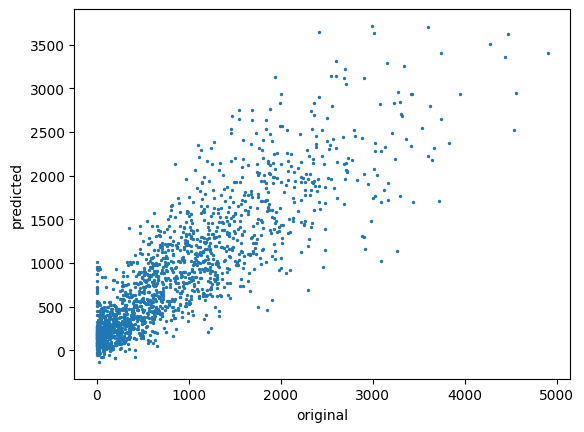

In [ ]:
from matplotlib import pyplot as plt
new2.plot(kind='scatter', x='original', y='predicted', s=2, alpha=1)
plt.gca().spines[['top', 'right',]].set_visible(True)

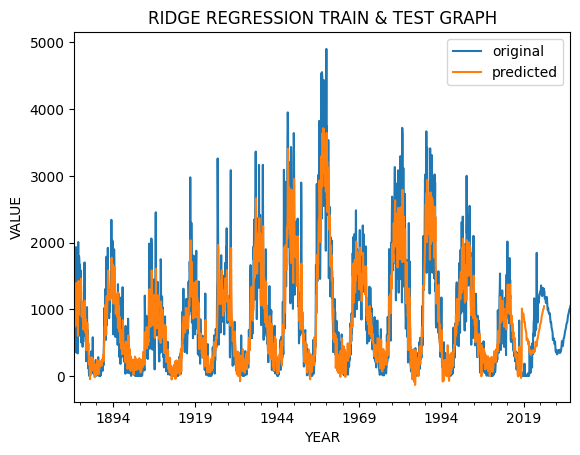

In [ ]:
new2.plot()
plt.title('RIDGE REGRESSION TRAIN & TEST GRAPH',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_train_test.png')

In [ ]:
len(test_pred),len(val_yd)

(82, 82)

In [ ]:
len(new_d1)

1812

In [ ]:
new_d.query('Area < 10')

,Area
1877-07,4.2
1878-04,0.4
1878-07,0.4
1878-08,0.0
1878-10,9.6
...,...
2020-02,1.4
2020-03,1.4
2020-04,7.5
2020-05,1.8


In [ ]:
import numpy as np

t_df = np.array(new_d).reshape(-1,1)

In [ ]:
len(t_df)

1908

In [ ]:
fut_inp = t_df[1812:]

In [ ]:
fut_inp = fut_inp.reshape(1,-1)

In [ ]:
tmp_inp = list(fut_inp)

In [ ]:
fut_inp.shape

(1, 96)

In [ ]:
tmp_inp = tmp_inp[0].tolist()

In [ ]:
predictions2

array([[1010.4427567 ],
       [ 957.67802829],
       [ 949.06569752],
       [ 922.66364346],
       [ 925.57996242],
       [ 931.94141511],
       [ 930.46852546],
       [ 870.85341549],
       [ 843.91171908],
       [ 801.90828025],
       [ 806.48914153],
       [ 787.84269772],
       [ 725.19916947],
       [ 710.87197018],
       [ 691.18313047],
       [ 664.25222633],
       [ 649.76904807],
       [ 539.45932243],
       [ 542.34808578],
       [ 551.71287621],
       [ 560.31418354],
       [ 548.37309786],
       [ 511.16890831],
       [ 474.87670655],
       [ 475.58224072],
       [ 518.62042809],
       [ 448.40797314],
       [ 376.36620196],
       [ 360.57394458],
       [ 355.90136307],
       [ 381.82198431],
       [ 363.23652493],
       [ 317.01768017],
       [ 324.98871925],
       [ 370.87809265],
       [ 357.41375864],
       [ 379.70297872],
       [ 344.95988834],
       [ 354.63648781],
       [ 356.88476074],
       [ 364.23900264],
       [ 386.916

In [ ]:
lst_output=[]
n_steps=96
i=0
while(i<120):

    if(len(tmp_inp)>96):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape(( 1,n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps))
        yhat = best_model.predict(fut_inp).reshape(-1,1)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1

lst_output

[[1076.8644061129287],
 [1083.5893825546395],
 [1096.4082349703654],
 [1104.8420685413696],
 [1140.9137401692383],
 [1165.321600809807],
 [1165.9762298330993],
 [1164.817231449282],
 [1160.4082365191423],
 [1176.611279812619],
 [1197.368406958661],
 [1198.5304927480195],
 [1203.4395703180046],
 [1202.6884779358188],
 [1217.3604528369895],
 [1231.9159057304898],
 [1241.5800254918747],
 [1230.488742097074],
 [1229.6837986888943],
 [1228.5680043287232],
 [1232.8775348297058],
 [1228.7890953323133],
 [1218.3239646015188],
 [1210.768097426568],
 [1205.9927438530328],
 [1202.21312199615],
 [1189.748964982785],
 [1175.7544617722951],
 [1165.4736685405317],
 [1160.147690122962],
 [1164.1436128531918],
 [1151.1284053692755],
 [1138.107563903666],
 [1117.3905901913074],
 [1104.275234061159],
 [1096.2760867464847],
 [1077.2887453695098],
 [1054.2026293513045],
 [1034.091553819053],
 [1018.2844896298832],
 [1006.937569393659],
 [994.4108062097454],
 [973.8628668810583],
 [955.763449268946],
 [941.

In [ ]:
n_steps=96

X1,y1=prepare_data(t_df,n_steps)

In [ ]:
X1.shape

(1812, 96, 1)

In [ ]:
X1 = np.array([X1]).reshape(1812, 96)

In [ ]:
train_p=best_model.predict(X1).reshape(-1,1)

In [ ]:
type(train_p)

numpy.ndarray

In [ ]:
test_2 = np.vstack((train_p,lst_output))

In [ ]:
test_2=test_2.flatten()

In [ ]:
data_n = np.array(data_n).reshape(-1,1)

In [ ]:
data_s2 = data_n[96:]

In [ ]:
test_2.shape

(1932,)

In [ ]:
date=pd.Series(pd.period_range("1882-05-01", freq="M", periods=len(new_d1)+120))

In [ ]:
DF = pd.DataFrame()
DF['original'] = new_d1
DF = DF.set_index(date[:-120])

In [ ]:
DF1=pd.DataFrame()
DF1['predicted']=test_2
DF1 = DF1.set_index(date)

In [ ]:
new = pd.concat([DF, DF1], ignore_index=False, axis=1)
new

,original,predicted
1882-05,1519.6,1264.097414
1882-06,557.8,1214.477187
1882-07,461.5,877.702541
1882-08,607.6,741.753544
1882-09,1026.9,793.077662
...,...,...
2042-12,NaN,906.601679
2043-01,NaN,920.556640
2043-02,NaN,935.260271
2043-03,NaN,948.780790


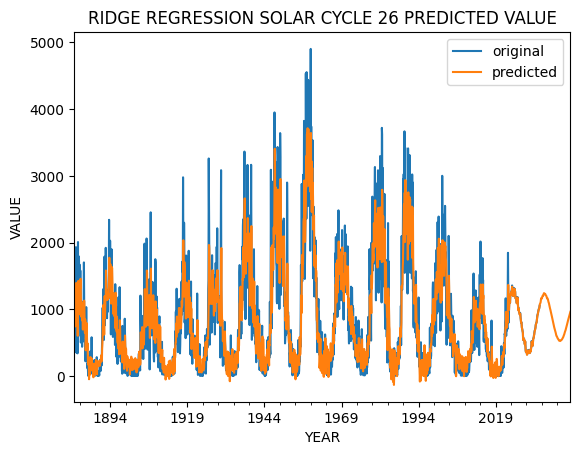

In [ ]:
new.plot()
plt.title('RIDGE REGRESSION SOLAR CYCLE 26 PREDICTED VALUE',color='black')
plt.xlabel('YEAR',color='black')
plt.ylabel('VALUE',color='black')
plt.savefig('RF_predict.png')

In [ ]:
print("Largest element is:", max(lst_output))

Largest element is: [1241.5800254918747]


In [ ]:
i=max(lst_output)
time=int(np.where(np.array(lst_output) == i)[0])
time

<ipython-input-135-75ffc8ac41e8>:2: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  time=int(np.where(np.array(lst_output) == i)[0])


16

In [ ]:
new_date = np.datetime64('2033-05') + np.timedelta64(time, 'M')
print('Peak month is : '+str(new_date))


Peak month is : 2034-09


In [ ]:
new.query('predicted <= 0')

,original,predicted
1887-02,75.6,-48.612557
1888-07,22.2,-19.309529
1911-12,15.5,-52.506987
1912-01,0.0,-15.719266
1912-12,81.6,-15.594488
1913-02,23.2,-43.416719
1932-10,71.0,-78.412384
1954-01,0.7,-36.833769
1954-02,1.4,-49.463523
1963-04,303.0,-12.178139
